In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from warnings import warn

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, mark_inset
from scipy.interpolate import RegularGridInterpolator, UnivariateSpline
from scipy.optimize import fmin
from tqdm.auto import tqdm

from bounded_rand_walkers.cpp import (
    bound_map,
    freehand2,
    generate_data,
    get_binned_2D,
    get_binned_data,
    get_cached_filename,
    get_max_step,
)
from bounded_rand_walkers.shaper_generation import gen_rad_shaper_exact
from bounded_rand_walkers.utils import cache_dir, get_centres, match_ref, normalise

mpl.rc_file("matplotlibrc")
Path("plots").mkdir(exist_ok=True)

In [2]:
# Generate a single set of data.

pdf_kwargs = dict(width=2.0)


def get_raw_f_i(r):
    """Calculate f_i at given radii."""
    return np.array([freehand2([c, 0], **pdf_kwargs) for c in r])


bound_name = "square"
n_bins = 300  # Nr. of x, y bins.
n_raw_shaper = 10000  # Number of data points used to construct the shaper spline.
sub_exp = 5  # 10^sub_exp data points will be used per run to generate the numerics
# envelope.
n_multiple = 10000  # Number of experimental runs with 10^sub_exp samples each.
# The number of times a run with 10^sub_exp samples is expected
# to contain a sample in the bin with the lowest probability.
min_occurrences = 4

data_kwargs = dict(
    cache_dir=cache_dir,
    samples=int(1e7),
    seed=np.arange(10),
    blocks=2,
    bound_name=bound_name,
    pdf_name="freehand2",
    **pdf_kwargs
)

#### Use the analytical f_t distribution to inform the bin sizes.

Bins will be created from 0 all the way up to the maximum expected bin size.

In [3]:
max_step = get_max_step(bound_name)

# Analytical f_i cdf spline.
cdf_f_i_radii = np.linspace(0, 2 * max_step, 1000000)
cdf_f_i_analytical = np.cumsum(get_raw_f_i(cdf_f_i_radii))
cdf_f_i_analytical /= cdf_f_i_analytical[-1]
cdf_f_i_spl = UnivariateSpline(cdf_f_i_radii, cdf_f_i_analytical, s=0, ext="const")

# 1D shaper calculation.
shaper_radii = np.linspace(0, max_step, n_raw_shaper)
raw_r_shaper = gen_rad_shaper_exact(shaper_radii, vertices=bound_name)

# Using a spline, calculate the shaper at further points.
shaper_spl = UnivariateSpline(shaper_radii, raw_r_shaper, s=0, ext="zeros")

# Generate a spline for the 'cumulative' shaper to estimate average values across bins.
cumsum_shaper = np.cumsum(raw_r_shaper)
cumsum_shaper /= cumsum_shaper[-1]
cum_shaper_spl = UnivariateSpline(shaper_radii, cumsum_shaper, s=0, ext="const")

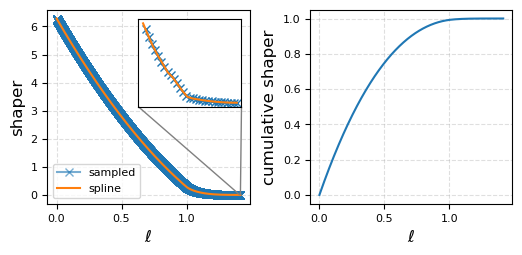

In [4]:
n_shaper_spl = 1000  # Number of points for the spline plots.

fig, axes = plt.subplots(1, 2, figsize=(6, 2.52))

ax = axes[0]

ax.plot(shaper_radii, raw_r_shaper, marker="x", label="sampled", alpha=0.6)

spl_shaper_radii = np.linspace(0, max_step, n_shaper_spl)
ax.plot(spl_shaper_radii, shaper_spl(spl_shaper_radii), label="spline")

ax.set_xlabel(r"$\ell$")
ax.set_ylabel("shaper")

ax2 = plt.axes([0, 0, 1, 1])

# Start of the inset region (and up until the maximum possible step size).
x_start = 1.41

ax2.set_xticks([])
ax2.set_yticks([])

sel = (x_start <= shaper_radii) & (shaper_radii <= max_step)
ax2.plot(shaper_radii[sel], raw_r_shaper[sel], marker="x")
sel_rad = np.linspace(x_start, max_step, 20)
ax2.plot(sel_rad, shaper_spl(sel_rad))

ip = InsetPosition(ax, [0.45, 0.5, 0.51, 0.45])
ax2.set_axes_locator(ip)
mark_inset(ax, ax2, loc1=3, loc2=4, fc="none", ec="0.5")

ax.legend(loc=3)

ax = axes[1]

ax.plot(spl_shaper_radii, cum_shaper_spl(spl_shaper_radii))
ax.set_ylabel("cumulative shaper")
ax.set_xlabel(r"$\ell$")

plt.subplots_adjust(wspace=0.3)

#### Approximate the CDF

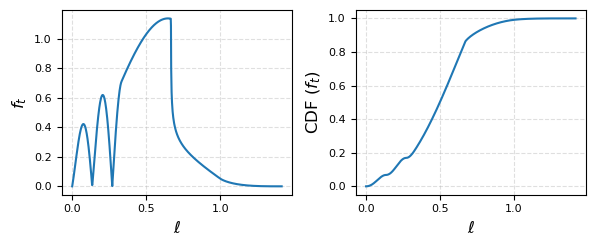

In [5]:
# Create a function to calculate the analytical transformed f_t.
def get_f_t_r_analytical(r):
    return get_raw_f_i(r) * shaper_spl(r) * r


# Take many samples in order to calculate the cdf.
cdf_r = np.linspace(0, max_step, 1000000)
cdf_t_r_analytical = np.cumsum(get_f_t_r_analytical(cdf_r))
cdf_t_r_analytical /= cdf_t_r_analytical[-1]

# Use spline interpolation to calculate the CDF at arbitrary positions based on the above.
cdf_f_t_spl = UnivariateSpline(cdf_r, cdf_t_r_analytical, s=0, ext="const")

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
plot_ls = np.linspace(0, max_step, 1000)
axes[0].plot(plot_ls, get_f_t_r_analytical(plot_ls))
axes[0].set_xlabel(r"$\ell$")
axes[0].set_ylabel(r"$f_t$")
axes[1].plot(plot_ls, cdf_f_t_spl(plot_ls))
axes[1].set_xlabel(r"$\ell$")
axes[1].set_ylabel(r"CDF ($f_t$)")
fig.tight_layout()

#### Interpolate the CDF at chosen intervals in order to determine the set of bin edges satisfying the minimum nr. of expected samples for any bin

In [6]:
last_min_expected = None
for n in range(2, 10000):
    edges = np.linspace(0, max_step, n)
    edge_probs = np.interp(edges, cdf_r, cdf_t_r_analytical)
    bin_probs = np.diff(edge_probs)
    min_expected = np.min(bin_probs) * 10 ** sub_exp
    if min_expected < min_occurrences / n_multiple:
        break
    last_min_expected = min_expected

n_rad = n - 1
assert n_rad >= 2
print("Nr. of radial bins:", n_rad)
print(
    f"Expected min. nr. of samples for 10^{sub_exp} samples: {last_min_expected:0.5f}"
)

Nr. of radial bins: 118
Expected min. nr. of samples for 10^5 samples: 0.00041


#### Generate numerics

In [7]:
filenames = get_cached_filename(squeeze=False, **data_kwargs)
if not all(p.is_file() for p in filenames):
    generate_data(
        squeeze=False, max_workers=cpu_count(), cache_only=True, **data_kwargs
    )

(
    g_x_edges,
    g_y_edges,
    g_x_centres,
    g_y_centres,
    f_t_x_edges,
    f_t_y_edges,
    f_t_x_centres,
    f_t_y_centres,
    f_t_r_edges,
    f_t_r_centres,
    g_numerical,
    f_t_numerical,
    f_t_r_numerical,
) = get_binned_data(
    filenames=filenames,
    n_bins=n_bins,
    g_bounds=(-0.5, 0.5),
    f_bounds=(-1, 1),
    f_t_r_edges=np.linspace(0, max_step, n_rad),
)

In [8]:
# Select valid elements.
r_shaper = np.diff(cum_shaper_spl(f_t_r_edges))
valid_r = r_shaper > 0

f_i_r_num_radii = f_t_r_centres[valid_r].copy()

# Analytical calculations.

f_i_r_analytical = np.diff(cdf_f_i_spl(f_t_r_edges))

# 1D analytical transformed distribution.
f_t_r_analytical = f_i_r_analytical * r_shaper

# Analytical transformed.
f_i_r_analytical_trans = f_t_r_analytical[valid_r] / r_shaper[valid_r]

f_t_norm = normalise(f_t_r_edges, f_t_r_analytical * f_t_r_centres)

# Numerics calculations.

# 1D reconstruction of the intrinsic pdf as a function of step length only.
f_i_r_num = f_t_r_numerical[valid_r] / r_shaper[valid_r]

In [9]:
# Generate multiple sets of data in order to visualise the uncertainty.
sub_data_kwargs = data_kwargs.copy()
sub_data_kwargs["samples"] = int(10 ** sub_exp)
sub_data_kwargs["seed"] = np.arange(n_multiple)

sub_filenames = get_cached_filename(squeeze=False, **sub_data_kwargs)
if not all(p.is_file() for p in sub_filenames):
    generate_data(
        squeeze=False, max_workers=cpu_count(), cache_only=True, **sub_data_kwargs
    )

In [10]:
# Manually bin the step sizes radially to compute minimum and maximum bounds.
ignore_initial = 1000

f_t_r_num_all = np.empty(
    (len(sub_data_kwargs["seed"]), f_t_r_centres.size), dtype=np.float64
)

for i, filename in enumerate(
    tqdm(sub_filenames, desc="Binning data radially", smoothing=0)
):
    if filename is not None and filename.is_file():
        # Cached data exists.
        saved = np.load(filename)
        positions = saved["positions"][ignore_initial:]
        steps = saved["steps"][ignore_initial:]
        saved.close()
    else:
        warn(f"Filename '{filename}' was not found.")
        continue

    # Radially bin the step size data.
    f_t_r_num_all[i] = np.histogram(np.linalg.norm(steps, axis=1), bins=f_t_r_edges)[0]

In [11]:
f_t_r_num_mins = np.min(f_t_r_num_all, axis=0)
f_t_r_num_maxs = np.max(f_t_r_num_all, axis=0)
f_t_r_num_stds = np.std(f_t_r_num_all, axis=0)
f_t_r_num_mean = np.mean(f_t_r_num_all, axis=0)

In [12]:
# 1D reconstruction of the intrinsic pdf as a function of step length only.
f_i_r_all_list = []
for i in range(f_t_r_num_all.shape[0]):
    f_i_r_all_list.append((f_t_r_num_all[i][valid_r] / r_shaper[valid_r])[None])
f_i_r_num_all = np.vstack(f_i_r_all_list)

f_i_r_num_mins = np.min(f_i_r_num_all, axis=0)
f_i_r_num_maxs = np.max(f_i_r_num_all, axis=0)
f_i_r_num_stds = np.std(f_i_r_num_all, axis=0)
f_i_r_num_mean = np.mean(f_i_r_num_all, axis=0)

In [13]:
# Analytical normed f_t.
# Reference for all f_t plots.
f_t_r_analytical_norm = normalise(f_t_r_edges, f_t_r_analytical * f_t_r_centres)

# Numerical f_t normalisation factor.
f_t_num_mean_factor = match_ref(
    x=f_t_r_centres,
    y=f_t_r_num_mean,
    ref_x=f_t_r_centres,
    ref_y=f_t_r_analytical_norm,
    return_factor=True,
)

f_t_num_factor = normalise(
    f_t_r_edges,
    f_t_r_numerical,
    return_factor=True,
)

In [14]:
bin_width = np.mean(np.diff(f_t_r_edges))
analytical_f_i_edges = np.arange(0, 1.7 + bin_width, bin_width)
analytical_f_i_centres = get_centres(analytical_f_i_edges)

analytical_f_i = np.diff(cdf_f_i_spl(analytical_f_i_edges)) * analytical_f_i_centres
# Ensure the pdf is 0 beyond 1.6.
analytical_f_i[analytical_f_i_centres > 1.6] = 0

# Normalise the full f_i distribution.
analytical_f_i = normalise(
    analytical_f_i_edges,
    analytical_f_i,
)

# For (a), only plot the analytical f_i within the maximum step length.
f_i_restr = analytical_f_i_centres < max_step
analytical_f_i_centres_restr = analytical_f_i_centres[f_i_restr]
analytical_f_i_restr = analytical_f_i[f_i_restr]

# Analytical transformed, normed f_i.
f_i_r_analytical_trans_norm = normalise(
    f_i_r_num_radii, f_i_r_analytical_trans * f_i_r_num_radii
)
f_i_ref_radii_sel = analytical_f_i_centres < fmin(
    lambda x: (cdf_f_t_spl(x[0]) - 0.8) ** 2, [0.7 * max_step], disp=False
)
f_i_ref_radii = analytical_f_i_centres[f_i_ref_radii_sel]
f_i_ref = analytical_f_i[f_i_ref_radii_sel]

# Lower samples numerical mean scaling factor.
f_i_num_mean_factor = match_ref(
    x=f_i_r_num_radii,
    y=f_i_r_num_mean,
    ref_x=f_i_ref_radii,
    ref_y=f_i_ref,
    return_factor=True,
)

# Higher samples numerical scaling factor.
f_i_num_factor = match_ref(
    x=f_i_r_num_radii,
    y=f_i_r_num,
    ref_x=f_i_ref_radii,
    ref_y=f_i_ref,
    return_factor=True,
)

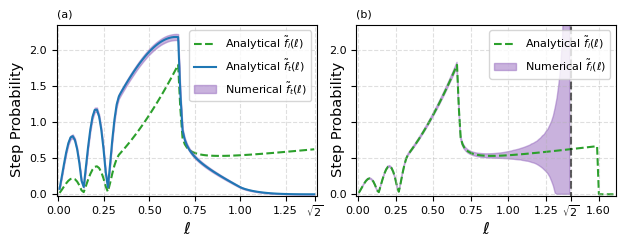

In [15]:
analytical_str = "Analytical"
numerical_str = "Numerical"

analytical_f_i_kwargs = dict(
    label=f"{analytical_str} " r"$\tilde{f}_i(\ell)$",
    zorder=1,
    linestyle="--",
    c="C2",
)

# Plot f_t and f_i.
fig, axes = plt.subplots(1, 2, figsize=(6.3, 2.52))

# Plot f_t.
ax = axes[0]

# Plot this for comparison.
ax.plot(
    analytical_f_i_centres_restr,
    analytical_f_i_restr,
    **analytical_f_i_kwargs,
)

ax.plot(
    f_t_r_centres,
    f_t_r_analytical_norm,
    label=f"{analytical_str} " r"$\tilde{f}_t(\ell)$",
    zorder=3,
)

f_t_factor = normalise(f_t_r_edges, f_t_r_num_mean, return_factor=True)
ax.fill_between(
    f_t_r_centres,
    np.clip(f_t_num_mean_factor * (f_t_r_num_mean - f_t_r_num_stds), 0, None),
    f_t_num_mean_factor * (f_t_r_num_mean + f_t_r_num_stds),
    alpha=0.5,
    zorder=2,
    color="C4",
    label=f"{numerical_str} " r"$\tilde{f}_t(\ell)$",
)

# Plot f_i.
ax = axes[1]

ax.plot(
    analytical_f_i_centres,
    analytical_f_i,
    **analytical_f_i_kwargs,
)

num_f_i_kwargs = dict(
    alpha=0.5,
    zorder=1,
    color="C4",
    label=f"{numerical_str} " r"$\tilde{f}_i(\ell)$",
)
ax.fill_between(
    f_i_r_num_radii,
    np.clip(f_i_num_mean_factor * (f_i_r_num_mean - f_i_r_num_stds), 0, None),
    f_i_num_mean_factor * (f_i_r_num_mean + f_i_r_num_stds),
    **num_f_i_kwargs,
)

# Labels.
for ax in axes:
    ax.set_xlabel(r"$\ell$")

ylabel = "Step Probability    "
ylabel_fs = mpl.rcParams["axes.labelsize"] - 1.5
axes[0].set_ylabel(ylabel, fontsize=ylabel_fs)
axes[1].set_ylabel(ylabel, labelpad=-12, fontsize=ylabel_fs)

# Grids and titles.
for ax, title in zip(axes, ["(a)", "(b)"]):
    ax.text(0, 1.04, title, transform=ax.transAxes)

ylim = (-0.02, 2.35)

for ax in axes:
    ax.set_ylim(*ylim)

axes[1].set_yticks(axes[1].get_yticks())

# Add vertical lines to show the maximum step size.
max_step_kwargs = dict(
    linestyle="--",
    alpha=0.6,
    color="k",
)

axes[1].vlines(max_step, -1, 3, **max_step_kwargs)

for ax in axes:
    ax.set_ylim(*ylim)
    ax.margins(x=0.01, y=None)

# Legends.
axes[0].legend(loc="upper right")

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], **analytical_f_i_kwargs),
    Patch(**num_f_i_kwargs),
    Line2D([0], [0], **max_step_kwargs),
]

# (b) legend.

# Single top-right legend.
axes[1].legend(handles=legend_elements[:2], loc="upper right")

axes[1].set_yticklabels(["", "0.0", "", "", "", "2.0", ""])

# Move the two subplots closer to each other.
fig.tight_layout()

# Manually adjust (a) ticks and ticklabels.
xlim = axes[0].get_xlim()
xticks = np.linspace(0, 1.25, 6)
xticks = np.append(xticks, np.sqrt(2))
axes[0].set_xticks(xticks)
axes[0].set_xlim(*xlim)
xticklabels = [format(l, "0.2f") for l in xticks]
xticklabels[-1] = ""
# Add the math symbol for sqrt(2) manually to correct the default offset.
axes[0].set_xticklabels(xticklabels)
axes[0].text(max_step, -0.228, r"$\sqrt{2}$", ha="center", va="center")

# Manually adjust (b) ticks and ticklabels.
xlim = axes[1].get_xlim()
xticks = np.arange(0, 1.8, 0.25)
xticks[-2] = np.sqrt(2)
xticks[-1] = 1.6
axes[1].set_xticks(xticks)
axes[1].set_xlim(*xlim)
xticklabels = [format(l, "0.2f") for l in xticks]
# Add the math symbol for sqrt(2) manually to correct the default offset.
xticklabels[-2] = ""
axes[1].set_xticklabels(xticklabels)
axes[1].text(max_step, -0.228, r"$\sqrt{2}$", ha="center", va="center")

# Finally, save into the 'plots' directory.
fig.savefig((Path("plots") / f"{bound_name}_reconstruction").with_suffix(".pdf"))